In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import string
import random
from typing import List, Tuple
import math
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import log
import mynlputils as nu

In [2]:
logger = log.get_logger(__name__)

In [3]:
@nu.timer
def load_data(raw_txt_train_path: str, raw_txt_test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train = pd.read_csv(raw_txt_train_path, header=None, names=["label", "title", "description"])
    df_test = pd.read_csv(raw_txt_test_path, header=None, names=["label", "title", "description"])
    return df_train[["label", "description"]], df_test[["label", "description"]]

@nu.timer
def create_validation_set(corpus: pd.DataFrame, valid_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_corpus, valid_corpus = train_test_split(corpus, test_size=valid_size, random_state=1)
    return train_corpus.reset_index(drop=True), valid_corpus.reset_index(drop=True)

@nu.timer
def clean_text(docs: pd.DataFrame) -> pd.DataFrame:
    clean_docs = docs['description']
    clean_docs = clean_docs.str.replace("-", " ")
    clean_docs = clean_docs.str.replace("quot;", " ")
    clean_docs = clean_docs.str.replace("#39;s", "'")
    translation_table = str.maketrans('', '', string.punctuation)
    clean_docs = clean_docs.str.translate(translation_table)
    clean_docs = clean_docs.str.lower()
    clean_docs = clean_docs.str.replace(r'\d+', ' <NUM> ')
    clean_docs = clean_docs.str.replace(r'\s+', ' ')
    return clean_docs.to_frame()

@nu.timer
def split_docs(docs: pd.DataFrame) -> pd.DataFrame:
    return docs['description'].str.split().to_list()

@nu.timer
def tokenize(tokens: List[List[str]], min_freq: int = 5):
    word_freq = Counter([word for sentence in tokens for word in sentence])
    vocab = [word for word, freq in word_freq.items() if freq >= min_freq]
    vocab = ['<PAD>', '<UNK>'] + vocab
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx_tokens = [[word2idx.get(word, 1) for word in sentence] for sentence in tokens]
    return vocab, idx_tokens, word2idx

@nu.timer
def create_skipgrams(corpus, window_size, pad_idx):
    data = []
    for sentence in corpus:
        padded_sentence = [pad_idx] * window_size + sentence + [pad_idx] * window_size
        for word_index in range(window_size, len(padded_sentence) - window_size):
            contexts = padded_sentence[word_index - window_size : word_index] + padded_sentence[word_index + 1 : word_index + window_size + 1]
            data.append((contexts, padded_sentence[word_index]))
    return data

@nu.timer
def create_batches(skipgrams, word2idx, pad_idx, batch_size=32, num_neg_samples=5):
    words_list = list(word2idx.keys())
    vocab_size = len(words_list)
    n = len(skipgrams)

    # Shuffle skipgrams
    random.shuffle(skipgrams)

    batches = []

    for batch_start in range(0, n, batch_size):
        context_batch = []
        target_batch = []
        negative_batch = []

        # Create batches
        for contexts, target in skipgrams[batch_start:batch_start + batch_size]:
            negatives = [random.choice(range(vocab_size)) for _ in range(num_neg_samples)]
            context_batch.append(torch.LongTensor(contexts))
            target_batch.append(torch.LongTensor([target]))
            negative_batch.append(torch.LongTensor(negatives))

        # If this is the last batch and it's not full, skip it
        if len(context_batch) < batch_size:
            continue

        # Pad context sequences in batch
        context_batch = pad_sequence(context_batch, batch_first=True, padding_value=pad_idx)

        # Convert target and negative batches to tensors
        target_batch = torch.stack(target_batch)
        negative_batch = torch.stack(negative_batch)

        batches.append((context_batch, target_batch, negative_batch))
        
    return batches


class CBOW_NS(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(CBOW_NS, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)

    def forward(self, context_words, target_word, negative_words):
        # Get embeddings for context words, target word and negative words
        context_embeds = self.embeddings(context_words)  # (batch_size, window_size*2, embed_size)
        target_embeds = self.embeddings(target_word)    # (batch_size, 1, embed_size)
        negative_embeds = self.embeddings(negative_words)# (batch_size, num_neg_samples, embed_size)

        # Sum the context word embeddings
        context_embeds_sum = torch.sum(context_embeds, dim=1, keepdim=True)  # (batch_size, 1, embed_size)

        # Compute positive score
        pos_score = torch.bmm(context_embeds_sum, target_embeds.transpose(1,2)) # (batch_size, 1, 1)
        pos_score = F.logsigmoid(pos_score)

        # Compute negative score
        neg_score = torch.bmm(context_embeds_sum, negative_embeds.transpose(1,2)) # (batch_size, 1, num_neg_samples)
        neg_score = F.logsigmoid(-neg_score)

        # Return negative of total score
        return -(torch.sum(pos_score) + torch.sum(neg_score))
    
@nu.timer
def train(model, epochs, train_batches, val_batches, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        for context_batch, target_batch, negative_batch in train_batches:
            model.zero_grad()
            loss = model(context_batch, target_batch, negative_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        train_loss = total_loss / batch_count
        train_losses.append(train_loss)

        model.eval()  # set model to eval mode
        val_loss = evaluate(model, val_batches)
        val_losses.append(val_loss)

        logger.info(f'Epoch {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    return model, train_losses, val_losses


def evaluate(model, batches):
    total_loss = 0
    batch_count = 0
    with torch.no_grad():  # disable gradient computation to save memory
        for context_batch, target_batch, negative_batch in batches:
            loss = model(context_batch, target_batch, negative_batch)
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count


# def train(model, epochs, batches, lr=0.001):
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     losses = []
#     for epoch in range(epochs):
#         total_loss = 0
#         batch_count = 0
#         for context_batch, target_batch, negative_batch in batches:
#             model.zero_grad()
#             loss = model(context_batch, target_batch, negative_batch)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             batch_count += 1
#         avg_loss = total_loss / batch_count
#         losses.append(avg_loss)
#         logger.info(f'Epoch {epoch}, Loss: {avg_loss}')
#     return model, losses


# def plot_losses(losses, epochs):
#     # Plotting the losses
#     fig = px.line(x=list(range(epochs)), y=losses, labels={'x':'Epochs', 'y':'Loss'}, title='Loss over time')
#     fig.show()

def plot_losses(train_losses, val_losses, epochs):
    epochs_range = list(range(1, epochs + 1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs_range, y=train_losses, mode='lines', name='Train Loss'))
    fig.add_trace(go.Scatter(x=epochs_range, y=val_losses, mode='lines', name='Validation Loss'))
    fig.update_layout(title='Loss over Epochs', xaxis=dict(title='Epoch'), yaxis=dict(title='Loss'))
    fig.show()

In [4]:
conf = nu.load_config("a3")
df_train, df_test = load_data(conf.paths.raw_txt_train, conf.paths.raw_txt_test)
df_train, df_valid = create_validation_set(df_train, 0.1)
df_train_clean = clean_text(df_train)
df_valid_clean = clean_text(df_valid)
df_test_clean = clean_text(df_test)

train_tokens = split_docs(df_train_clean)
valid_tokens = split_docs(df_valid_clean)
test_tokens = split_docs(df_test_clean)

vocab, idx_train_tokens, word2idx = tokenize(train_tokens)
_, idx_valid_tokens, _ = tokenize(valid_tokens)
_, idx_test_tokens, _ = tokenize(test_tokens)

pad_idx = word2idx['<PAD>']
skipgrams_train = create_skipgrams(idx_train_tokens, window_size=2, pad_idx=pad_idx)
skipgrams_valid = create_skipgrams(idx_valid_tokens, window_size=2, pad_idx=pad_idx)
skipgrams_test = create_skipgrams(idx_test_tokens, window_size=2, pad_idx=pad_idx)

train_batches = create_batches(skipgrams_train, word2idx, pad_idx, batch_size=512)
valid_batches = create_batches(skipgrams_valid, word2idx, pad_idx, batch_size=512)
test_batches = create_batches(skipgrams_test, word2idx, pad_idx, batch_size=512)

23-Jul-23 23:20:50 - INFO - Starting 'load_config'.
23-Jul-23 23:20:50 - INFO - Finished 'load_config' in 0.0091 secs.
23-Jul-23 23:20:50 - INFO - Starting 'load_data'.
23-Jul-23 23:20:51 - INFO - Finished 'load_data' in 0.3090 secs.
23-Jul-23 23:20:51 - INFO - Starting 'create_validation_set'.
23-Jul-23 23:20:51 - INFO - Finished 'create_validation_set' in 0.0076 secs.
23-Jul-23 23:20:51 - INFO - Starting 'clean_text'.
/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_45598/538010891.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_docs = clean_docs.str.replace(r'\d+', ' <NUM> ')
/var/folders/0g/blggksdj42z52nv3fy0h5b880000gn/T/ipykernel_45598/538010891.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_docs = clean_docs.str.replace(r'\s+', ' ')
23-Jul-23 23:20:52 - INFO - Finished 'clean_text' in 1.4277 secs.
23-Jul-23 23:20:52 - INFO - Starting 'clean_text'.

In [5]:
vocab_size = len(vocab)
model = CBOW_NS(vocab_size, conf.model.embed_size)
trained_model, train_losses, val_losses = train(model, conf.model.epochs, train_batches, valid_batches, conf.model.lr)

23-Jul-23 23:21:34 - INFO - Starting 'train'.


KeyboardInterrupt: 

In [6]:
model = CBOW_NS(vocab_size, conf.model.embed_size)
model.load_state_dict(torch.load("../data/06_models/ap_news/cbow_ns_23072023_183858.pt"))

<All keys matched successfully>

In [7]:
plot_losses(train_losses, val_losses, conf.model.epochs)

NameError: name 'train_losses' is not defined

In [ ]:
nu.save_pytorch_model(trained_model, file_path=f"{conf.paths.models}cbow_ns_{nu._get_current_dt()}.pt")

In [8]:
# We retrieve the embeddings from the model
embeddings = model.embeddings.weight.data.numpy()

In [9]:
# Define pairs of words
word_pairs = [('nasa', 'space'), ('car', 'bus'), ('cat', 'dog')]

# Calculate cosine similarities
for word1, word2 in word_pairs:
    idx1 = word2idx[word1]
    idx2 = word2idx[word2]
    sim = cosine_similarity([embeddings[idx1]], [embeddings[idx2]])
    print(f"Similarity between {word1} and {word2}: {sim[0][0]}")

Similarity between nasa and space: 0.4396308660507202
Similarity between car and bus: 0.18682055175304413
Similarity between cat and dog: 0.057477667927742004


In [40]:
# Perform t-SNE
tsne = TSNE(n_components=3, random_state=42)  # reduce to 3 components
embeddings_tsne = tsne.fit_transform(embeddings)

/opt/homebrew/Caskroom/miniforge/base/envs/mlai_nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_nlp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
idx2word = {value: key for key, value in word2idx.items()}

In [41]:
# Convert to DataFrame
df = pd.DataFrame(embeddings_tsne, columns=['Dim1', 'Dim2', 'Dim3'])
df['word'] = idx2word.values()  # assuming idx2word is your index to word mapping

In [42]:
# Subset of words you're interested in
words = vocab[:100]  # replace with your words
df_subset = df[df['word'].isin(words)]

In [43]:
# Plot
fig = px.scatter_3d(df_subset, x='Dim1', y='Dim2', z='Dim3', text='word')
fig.show()

In [12]:
import matplotlib.pyplot as plt

In [10]:
# Perform PCA
pca = PCA(n_components=2)  # reduce to 2 components
embeddings_pca = pca.fit_transform(embeddings)

In [14]:
words = vocab[]

In [16]:
sorted_vocab = sorted(vocab) 

In [26]:
'beijing' in sorted_vocab

True

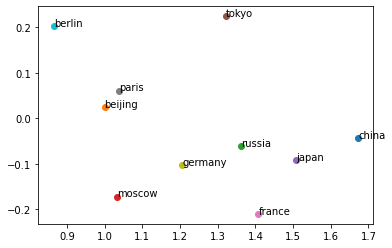

In [27]:
# Plot some words
words = ['china', 'beijing', 'russia', 'moscow', 'japan', 'tokyo', 'france', 'paris', 'germany', 'berlin']  # replace with your words
for word in words:
    idx = word2idx[word]
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1])
    plt.annotate(word, (embeddings_pca[idx, 0], embeddings_pca[idx, 1]))
plt.show()

In [28]:
def find_closest_embeddings(embedding, word, word2idx, idx2word, n=10):
    # Get the embedding for the word
    word_embedding = embedding[word2idx[word]]

    # Compute cosine similarities between word_embedding and all embeddings
    similarities = cosine_similarity([word_embedding], embedding)[0]

    # Get the indices of the top n similar embeddings
    closest_idxs = np.argsort(similarities)[-n:]

    # Convert these indices back to words and return
    closest_words_with_distances = [(idx2word[idx], similarities[idx]) for idx in reversed(closest_idxs)]

    return closest_words_with_distances

In [30]:
idx2word = {v: k for k, v in word2idx.items()}

In [32]:
word = "referendum"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('referendum', 1.0), ('recall', 0.40677977), ('ginter', 0.40064535), ('analyze', 0.39800185), ('concept', 0.3958459), ('oak', 0.38121623)]


In [33]:
word = "venezuela"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('venezuela', 1.0), ('davie', 0.40575475), ('uncommon', 0.38389525), ('traditionally', 0.3790345), ('steato', 0.37682575), ('bosnians', 0.37576467)]


In [34]:
word = "war"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('war', 1.0), ('torn', 0.53540725), ('terror', 0.52566016), ('between', 0.511223), ('against', 0.41544825), ('crimes', 0.40494663)]


In [35]:
word = "pope"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('pope', 1.0), ('allens', 0.50665796), ('leopard', 0.39513463), ('loopholes', 0.39341122), ('grouse', 0.38507998), ('sally', 0.37698418)]


In [36]:
word = "schumacher"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('schumacher', 1.0), ('michael', 0.41150188), ('eisner', 0.3847862), ('circus', 0.36715344), ('symbolic', 0.36696625), ('gameplay', 0.36256465)]


In [37]:
word = "ferrari"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('ferrari', 1.0), ('madison', 0.3909257), ('sheer', 0.37503532), ('rockers', 0.36956292), ('philosophical', 0.3661985), ('ddr', 0.36431968)]


In [38]:
word = "soccer"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('soccer', 0.9999999), ('league', 0.4791219), ('player', 0.47478947), ('teams', 0.4713383), ('team', 0.46328172), ('field', 0.45484388)]


In [39]:
word = "cricket"
n = 6
print(find_closest_embeddings(embeddings, word, word2idx, idx2word, n))

[('cricket', 1.0), ('title', 0.44584304), ('india', 0.426397), ('council', 0.4262874), ('test', 0.42543542), ('morning', 0.39616194)]
